# Load data, train model

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
# Load data
data = pd.read_csv('../data/brca_small.csv')
X = data.values[:, :-1]
Y = data.values[:, -1]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=100, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=100, random_state=1)

# Normalize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [3]:
def fit_model(x, y, x_val, y_val):
    # Cross validate for C
    C_list = np.arange(0.1, 1.0, 0.05)
    best_loss = np.inf
    best_C = None

    for C in C_list:
        # Fit model
        model = LogisticRegression(C=C, penalty='l1', multi_class='multinomial',
                                   solver='saga', max_iter=20000)
        model.fit(x, y)

        # Calculate loss
        val_loss = log_loss(y_val, model.predict_proba(x_val))

        # See if best
        if val_loss < best_loss:
            best_loss = val_loss
            best_C = C
            
    # Train model with all data
    model = LogisticRegression(C=best_C, penalty='l1', multi_class='multinomial',
                               solver='saga', max_iter=10000)
    model.fit(np.concatenate((x, x_val), axis=0),
              np.concatenate((y, y_val), axis=0))
    
    return model

In [4]:
# Train model
model = fit_model(X_train, Y_train, X_val, Y_val)

# SHAP cooperative game

In [5]:
import matplotlib.pyplot as plt
from shapreg import removal, games, shapley, shapley_unbiased

In [6]:
# Make model callable
model_lam = lambda x: model.predict_proba(x)

# Model extension
marginal_extension = removal.MarginalExtension(X_train, model_lam)

In [7]:
# Set up game (single prediction)
instance = X_test[0]
game = games.PredictionGame(marginal_extension, instance)

In [8]:
# Calculate SHAP values
explanation = shapley.ShapleyRegression(game, batch_size=64)

  0%|          | 0/1 [00:00<?, ?it/s]

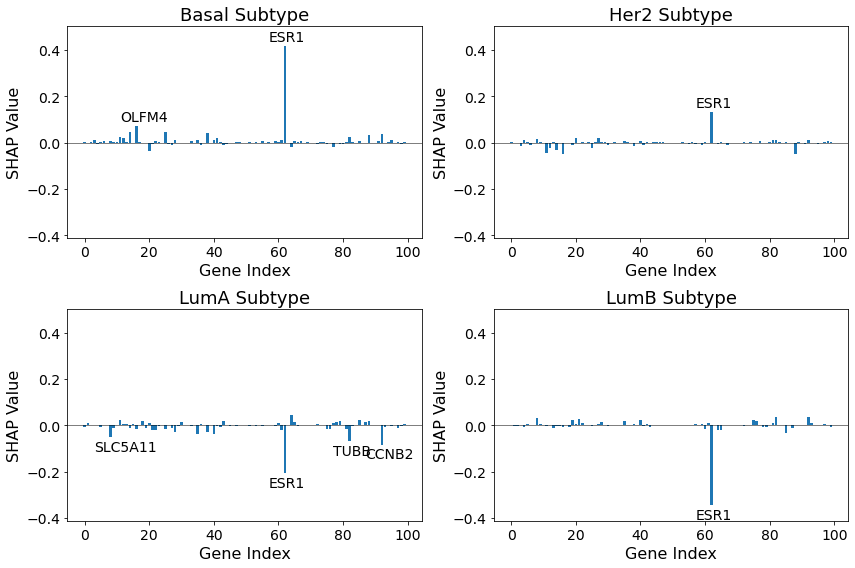

In [9]:
# Plot
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
label_names = ['Basal', 'Her2', 'LumA', 'LumB']
max_val = explanation.values.max()
min_val = explanation.values.min()

for i, name in enumerate(label_names):
    # Select axis and SHAP values
    ax = axarr[i // 2, i % 2]
    plt.sca(ax)
    values = explanation.values[:, i]
    
    # Plot
    plt.bar(np.arange(X.shape[1]), values)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title('{} Subtype'.format(name), fontsize=18)
    plt.ylim(min_val * 1.2, max_val * 1.2)
    plt.xlabel('Gene Index', fontsize=16)
    plt.ylabel('SHAP Value', fontsize=16)
    plt.tick_params(labelsize=14)
    
    # Label most important genes
    for i in range(len(values)):
        if values[i] > 0.05:
            plt.text(i - 5, values[i] + 0.02, data.columns[i], fontsize=14)
        elif values[i] < (- 0.05):
            plt.text(i - 5, values[i] - 0.06, data.columns[i], fontsize=14)

plt.tight_layout()
plt.show()